# Notebook

Notebook para mostrar los pasos seguidos y los métodos y datos utilizados para la estimación de ....

__Bibliotecas utilizadas__

In [1]:
import os
import sys
import getpass
import bz2
import pickle # Rick!
import copy

import numpy as np
import pandas as pd
import math

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.io import loadmat
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, Lasso, ElasticNet

__Funciones auxiliares__

In [2]:
def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

## Preprocesar los datos a utilizar

__Cargar los datos de matlab__

In [3]:
#df = loadmat("../../Data/Matlab/dB_ventana3.mat")
df = pd.read_csv("../../Data/csv/dB_eventos/dB_ventana3_60m.csv")

__Nombrar variables__
Para facilitar su uso

In [4]:
x_real=df.iloc[:,-2].values
y_real=df.iloc[:,-1].values

x_log = np.log(x_real)
y_log = np.log(y_real)

x_min=np.min(np.log(x_real))
x_max=np.max(np.log(x_real))

__Sacar medias para cada valor de duración__

In [5]:
data=[]
vals = np.unique(y_real)
for i in vals:
    pos = (i == y_real)
    data.append(np.mean(x_real[pos]))

## Relación entre variables RVR y duración de la niebla

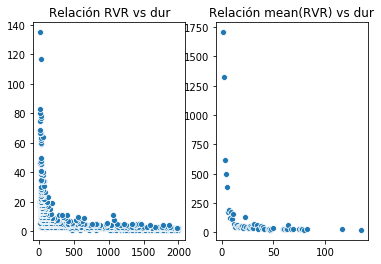

In [6]:
plt.subplot(1, 2, 1).set_title('Relación RVR vs dur')
sns.scatterplot(x=x_real,y=y_real)
plt.subplot(1, 2, 2).set_title('Relación mean(RVR) vs dur')
sns.scatterplot(x=vals, y=data)

Como tienen una distribución muy concreta y predecible, se podrían estimar los valores de duración a partir de la mínima visibilidad en el periodo. Se podría hacer un modelo de predicción estadística, que diera la media y stdev.

## Estimaciones

### Transformación Log-Log
Si se hace una transformación Log-Log de los datos, la estimación se podría hacer con modelo lineal (polinómico). Se visualiza una estimación polinómica de grado 2.

_Documentación de polyfit:_

* [Official SciPy page](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polynomial.polynomial.Polynomial.fit.html#numpy.polynomial.polynomial.Polynomial.fit)
* https://stackoverflow.com/a/3433503
* https://stackoverflow.com/a/46727862

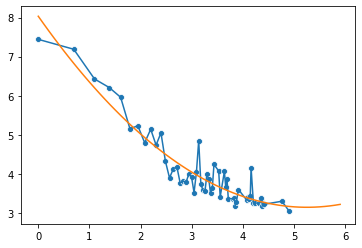

In [7]:
trend = np.polyfit(x=np.log(vals),y=np.log(data), deg=2)
trendpoly = np.poly1d(trend)
sns.lineplot(x=np.log(vals),y=np.log(data))
sns.scatterplot(x=np.log(vals),y=np.log(data))
sns.lineplot(np.arange(0,6,0.1),trendpoly(np.arange(0,6,0.1)))

### Estimación utilizando los valores medios de visibilidad para cada valor de duración

 Degree: 1 - RMSE: 0.3977651920607639
 Degree: 2 - RMSE: 0.30753968521864133
 Degree: 3 - RMSE: 0.29996205419541916
 Degree: 4 - RMSE: 0.27741980720119863


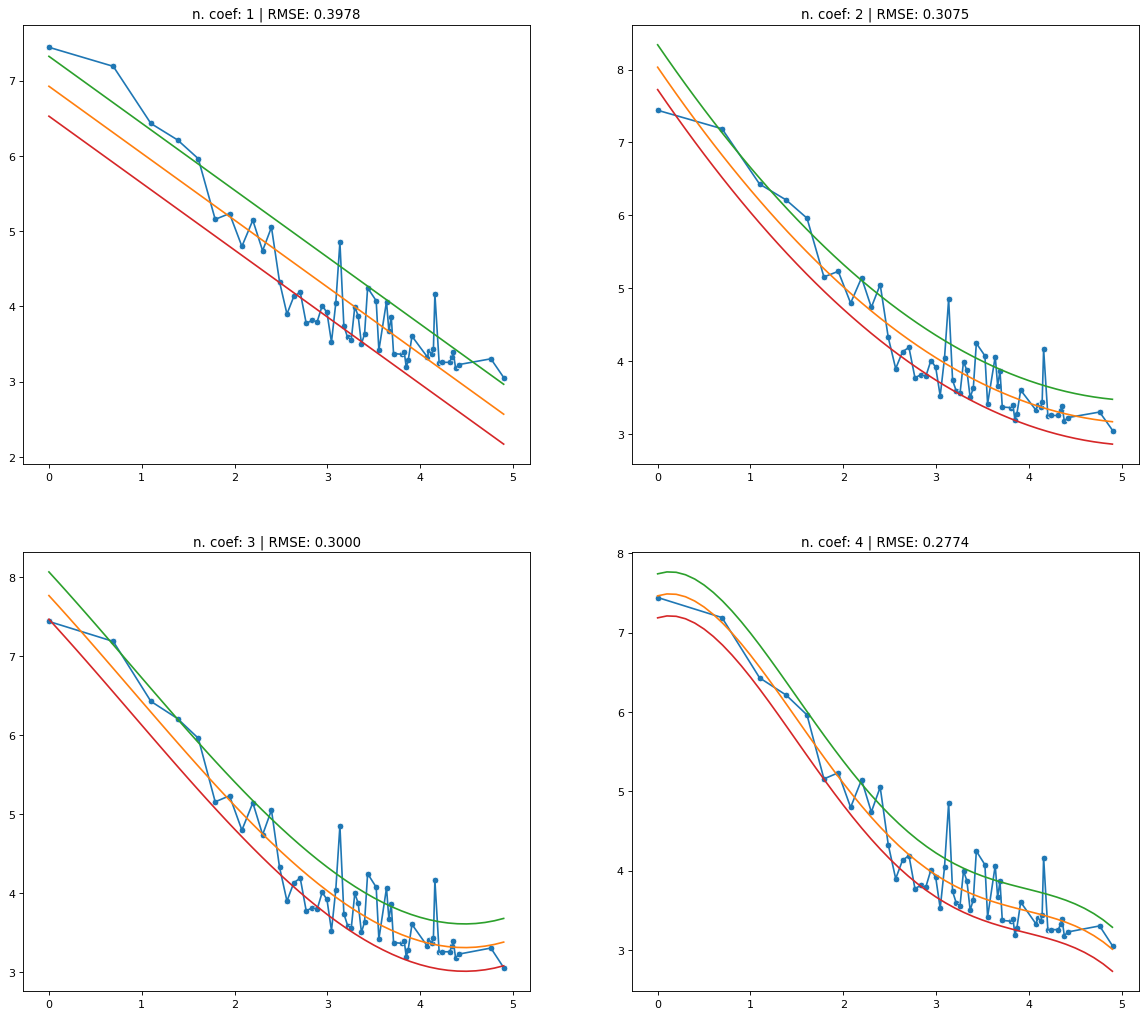

In [8]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

vals_min = np.min(np.log(vals))
vals_max = np.max(np.log(vals))

for i in range(1,5):
    trend = np.polyfit(x=np.log(vals),y=np.log(data), deg=i)
    trendpoly = np.poly1d(trend)
    # plt.plot(vals, data,'o')
    # plt.plot(trendpoly(vals), trendpoly(data), 'o')

    rmse = RMSE(trendpoly(np.log(vals)), np.log(data))
    
    plt.subplot(2, 2, i).set_title('n. coef: {} | RMSE: {:.4f}' .format(i, rmse))
    sns.lineplot(x=np.log(vals),y=np.log(data))
    sns.scatterplot(x=np.log(vals),y=np.log(data))
    sns.lineplot(np.arange(vals_min,vals_max,0.1),trendpoly(np.arange(vals_min,vals_max,0.1)))
    sns.lineplot(np.arange(vals_min,vals_max,0.1),trendpoly(np.arange(vals_min,vals_max,0.1))+rmse)
    sns.lineplot(np.arange(vals_min,vals_max,0.1),trendpoly(np.arange(vals_min,vals_max,0.1))-rmse)
    print(" Degree: " + str(i) + " - RMSE: " + str(rmse))

### Estimación utilizando los valores  reales de visibilidad

 Degree: 1 - RMSE: 0.5417116251610279
 Degree: 2 - RMSE: 0.5400472396693445
 Degree: 3 - RMSE: 0.5158787492780251
 Degree: 4 - RMSE: 0.5150185061809694


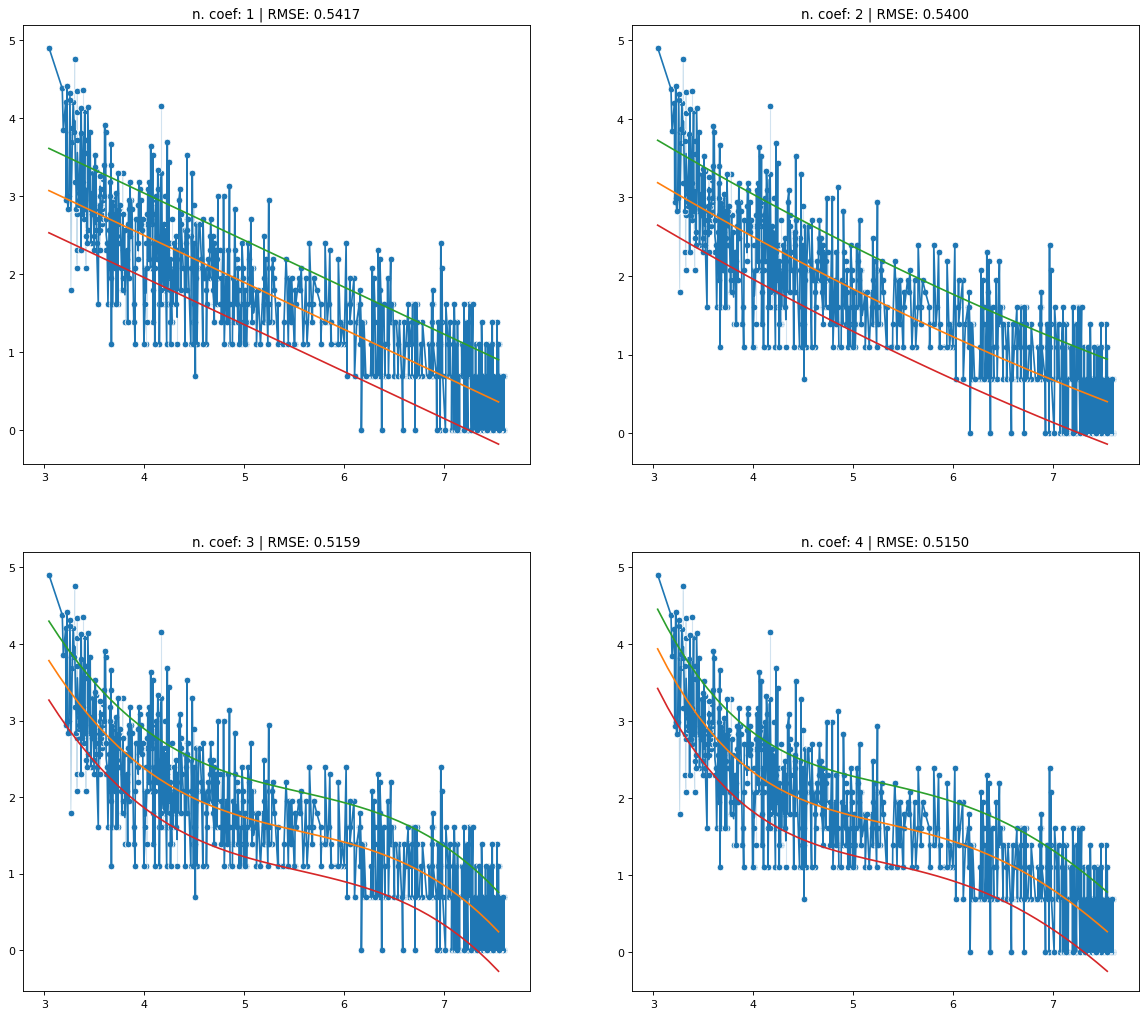

In [9]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

for i in range(1,5):
	trend = np.polyfit(x=np.log(x_real),y=np.log(y_real), deg=i)
	trendpoly = np.poly1d(trend)
	# plt.plot(x_real, y_real,'o')
	# plt.plot(trendpoly(x_real), trendpoly(y_real), 'o')

	rmse = RMSE(trendpoly(np.log(x_real)), np.log(y_real))

	plt.subplot(2, 2, i).set_title('n. coef: {} | RMSE: {:.4f}' .format(i, rmse))
	sns.lineplot(x=np.log(x_real),y=np.log(y_real))
	sns.scatterplot(x=np.log(x_real),y=np.log(y_real))
	sns.lineplot(x=np.arange(x_min,x_max,0.1),y=trendpoly(np.arange(x_min,x_max,0.1)))

	sns.lineplot(x=np.arange(x_min,x_max,0.1),
		         y=trendpoly(np.arange(x_min,x_max,0.1)) + rmse)
	sns.lineplot(x=np.arange(x_min,x_max,0.1),
		         y=trendpoly(np.arange(x_min,x_max,0.1)) - rmse)
	print(" Degree: " + str(i) + " - RMSE: " + str(rmse))


__Deshacer la transformación Log-Log__

 Degree: 1 - RMSE: 0.5417116251610279
 Degree: 2 - RMSE: 0.5400472396693445
 Degree: 3 - RMSE: 0.5158787492780251
 Degree: 4 - RMSE: 0.5150185061809694


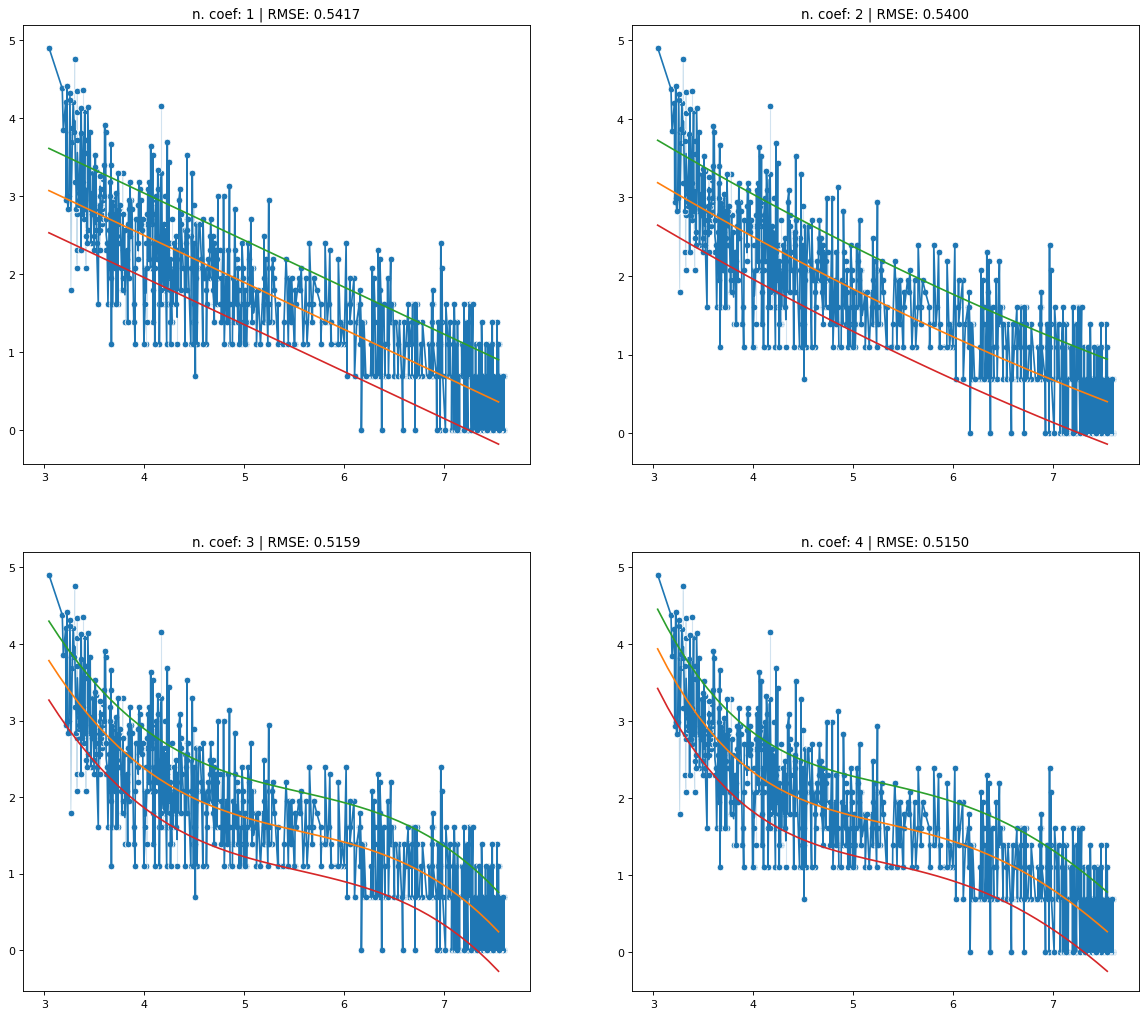

In [10]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

for i in range(1,5):
	trend = np.polyfit(x=np.log(x_real),y=np.log(y_real), deg=i)
	trendpoly = np.poly1d(trend)
	# plt.plot(x_real, y_real,'o')
	# plt.plot(trendpoly(x_real), trendpoly(y_real), 'o')

	rmse_ll = RMSE(trendpoly(np.log(x_real)), np.log(y_real))

	plt.subplot(2, 2, i).set_title('n. coef: {} | RMSE: {:.4f}' .format(i, rmse_ll))
	sns.lineplot(x=np.log(x_real),y=np.log(y_real))
	sns.scatterplot(x=np.log(x_real),y=np.log(y_real))
	sns.lineplot(x=np.arange(x_min,x_max,0.1),y=trendpoly(np.arange(x_min,x_max,0.1)))

	sns.lineplot(x=np.arange(x_min,x_max,0.1),
		         y=trendpoly(np.arange(x_min,x_max,0.1)) + rmse_ll)
	sns.lineplot(x=np.arange(x_min,x_max,0.1),
		         y=trendpoly(np.arange(x_min,x_max,0.1)) - rmse_ll)
	print(" Degree: " + str(i) + " - RMSE: " + str(rmse_ll))


### Estimación utilizando los valores  reales de visibilidad con modelos con regularización (Not Done)

__Estimación de con lm Ridge__

0.5417118156115899

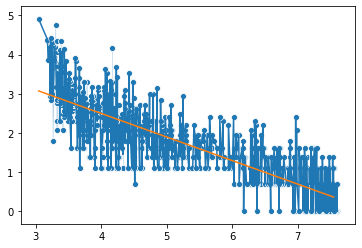

In [11]:
#Estimar los coeficientes del modelo con los datos con transformación logarítmica
lm_ridge = Ridge()
lm_ridge.fit(X=x_log.reshape(-1, 1), y=y_log)
lm_ridge.coef_
lm_ridge.intercept_

y_pred = lm_ridge.predict(x_log.reshape(-1, 1));
y_pred_line = lm_ridge.predict(np.arange(x_min,x_max,0.1).reshape(-1, 1))

sns.lineplot(x=np.log(x_real),y=np.log(y_real));
sns.scatterplot(x=np.log(x_real),y=np.log(y_real));
sns.lineplot(x=np.arange(x_min,x_max,0.1),y=y_pred_line);

RMSE(y_pred, y_log)

In [12]:
#np.arange(x_min,x_max,0.1)*lm_ridge.coef_+lm_ridge.intercept_
#lm_ridge.predict(np.arange(x_min,x_max,0.1).reshape(-1, 1))

__Estimación de con lm Lasso__

0.8535037223762237

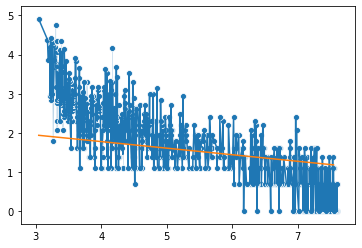

In [13]:
lm_lasso = Lasso()
lm_lasso.fit(X=x_log.reshape(-1, 1), y=y_log)
lm_lasso.coef_
lm_lasso.intercept_

y_pred = lm_lasso.predict(x_log.reshape(-1, 1));
y_pred_line = lm_lasso.predict(np.arange(x_min,x_max,0.1).reshape(-1, 1))

sns.lineplot(x=np.log(x_real),y=np.log(y_real))
sns.scatterplot(x=np.log(x_real),y=np.log(y_real))
sns.lineplot(x=np.arange(x_min,x_max,0.1),y=y_pred_line)

RMSE(y_pred, y_log)

__Estimación de con lm ElasticNet__

0.694232141513813

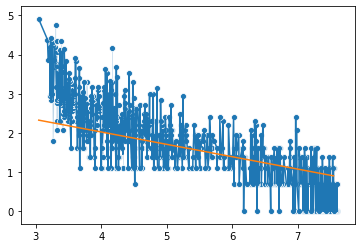

In [14]:
lm_el_net = ElasticNet()
lm_el_net.fit(X=x_log.reshape(-1, 1), y=y_log)
lm_el_net.coef_
lm_el_net.intercept_

y_pred = lm_el_net.predict(x_log.reshape(-1, 1));
y_pred_line = lm_el_net.predict(np.arange(x_min,x_max,0.1).reshape(-1, 1))

sns.lineplot(x=np.log(x_real),y=np.log(y_real))
sns.scatterplot(x=np.log(x_real),y=np.log(y_real))
sns.lineplot(x=np.arange(x_min,x_max,0.1),y=y_pred_line)

RMSE(y_pred, y_log)

__Estimación con MLP__

0.5423150338261905

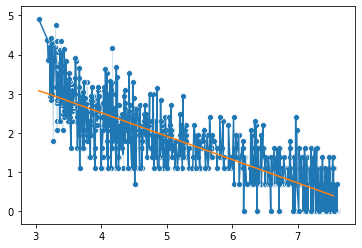

In [15]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor()
mlp.fit(X=x_log.reshape(-1, 1), y=y_log)

y_pred = mlp.predict(x_log.reshape(-1, 1));
y_pred_mlp = mlp.predict(np.arange(x_min,x_max,0.1).reshape(-1, 1))

sns.lineplot(x=np.log(x_real),y=np.log(y_real))
sns.scatterplot(x=np.log(x_real),y=np.log(y_real))
sns.lineplot(x=np.arange(x_min,x_max,0.1),y=y_pred_mlp)

RMSE(y_pred, y_log)

## Hacer conversión al dominio original
Hacer la conversión para deshacer la transformación Log-Log y ver qué tal van los modelos

In [16]:
np.e**trendpoly(np.arange(x_min,x_max,0.1))

array([51.49253811, 40.19266844, 32.07219171, 26.12631853, 21.69703853,
       18.34495353, 15.77118391, 13.76884388, 12.19232391, 10.93749951,
        9.92876436,  9.11039884,  8.44073755,  7.88817211,  7.42837552,
        7.04235142,  6.71504845,  6.434367  ,  6.19044254,  5.97512629,
        5.78160876,  5.60414791,  5.43787448,  5.27865471,  5.12299539,
        4.96797982,  4.81122538,  4.65085544,  4.48547913,  4.31417409,
        4.13646777,  3.95231425,  3.76206409,  3.56642609,  3.36642049,
        3.16332442,  2.9586109 ,  2.75388366,  2.55081037,  2.35105725,
        2.1562278 ,  1.96780837,  1.78712274,  1.61529713,  1.45323662,
        1.30161306])

<IPython.core.display.Javascript object>


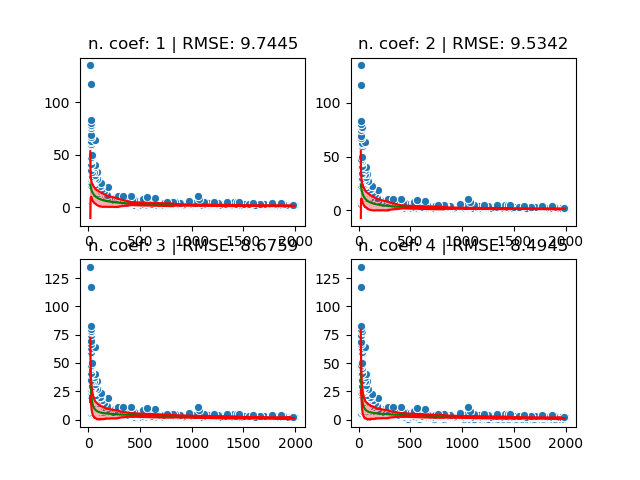

 Degree: 1 - RMSE: 9.74446830285937
 Degree: 2 - RMSE: 9.534166770417727
 Degree: 3 - RMSE: 8.675949362289384
 Degree: 4 - RMSE: 8.494473357607125


In [17]:
x_min_og=np.min(x_real)
x_max_og=np.max(x_real)

%matplotlib notebook

#fig=plt.figure(figsize=(50, 50), dpi= 80, facecolor='w', edgecolor='k')

x_linspace = np.linspace(x_min,x_max,875)



for i in range(1,5):
    #Hacer el ajuste polinomial de los datos
    [trend, residuals, rank, singular_values, rcond ] = np.polyfit(x=np.log(x_real),y=np.log(y_real), deg=i, full=True)
    trendpoly = np.poly1d(trend)
    # plt.plot(x_real, y_real,'o')
    # plt.plot(trendpoly(x_real), trendpoly(y_real), 'o')

    #Calcular el RMSE
    rmse_ll = RMSE(np.e**trendpoly(np.log(x_real)), y_real)
    #Calcular el CI para plotear
    err = np.e**trendpoly(np.log(x_real)) - y_real
    ci = pd.Series(err).rolling(250, min_periods=1).std()

    plt.subplot(2, 2, i).set_title('n. coef: {} | RMSE: {:.4f}' .format(i, rmse_ll))
    #sns.lineplot(x=np.log(x_real),y=np.log(y_real))
    sns.scatterplot(x=x_real, y=y_real)

    #Representación del modelo
    sns.lineplot(x=np.e**np.arange(x_min,x_max,0.1),
                 y=np.e**trendpoly(np.arange(x_min,x_max,0.1)),
                 color='green')
    #TODO:
    # * El 95% es 2*ci ¿?
    
    #Plotear el CI
    sns.lineplot(x=np.e**x_linspace,
                 y=np.e**trendpoly(x_linspace) + 2*ci[::-1],
                 color='red')
    sns.lineplot(x=np.e**x_linspace,
                 y=np.e**trendpoly(x_linspace) - 2*ci[::-1],
                 color='red')
    plt.fill_between(np.e**x_linspace,
                     np.e**trendpoly(x_linspace) + 2*ci[::-1],
                     np.e**trendpoly(x_linspace) - 2*ci[::-1],
                     color="red", alpha=0.3)
    #Plotear +- RMSE
    #sns.lineplot(x=np.e**x_linspace,
    #             y=np.e**trendpoly(x_linspace) + rmse_ll,
    #             color='orange')
    #sns.lineplot(x=np.e**x_linspace,
    #             y=np.e**trendpoly(x_linspace) - rmse_ll,
    #             color="orange")
    print(" Degree: " + str(i) + " - RMSE: " + str(rmse_ll))


In [18]:
RMSE(np.e**trendpoly(np.log(x_real)), y_real)

8.494473357607125

### TODO:

* Sacar $\sigma$
* Hacer test $H_0$ de normalidad